In [1]:
import pandas as pd
from rdkit import Chem
from tqdm import tqdm
from serenityff.charge.tree.dash_tree import DASHTree
from serenityff.charge.tree.atom_features import AtomFeatures
from rdkit import Chem
import torch
from custom_featurization_stuff import get_graph_from_mol
allowable_set= ["C","N","O","F","P","S","Cl","Br","I","H"]

In [3]:
tree = DASHTree(tree_folder_path='/localhome/cschiebroek/other/serenityff-charge/tree')

Loading DASH tree data


In [2]:
df_train_overall = pd.read_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/splits/OPERA_Naef_Training.csv')


In [38]:
molblocks = df_train_overall['molblock'].tolist()
all_mols = [Chem.MolFromMolBlock(molblock) for molblock in molblocks]
mols = [m for m in all_mols if m.GetNumAtoms() > 1]
error_mol = [m for m in all_mols if m.GetNumAtoms() <= 1]

In [39]:
mols_with_charges = []
error_mols_charges = []
for m in tqdm(mols):
    try:
        mol = Chem.AddHs(m, addCoords=True)
        charges = tree.get_molecules_partial_charges(mol,chg_std_key='std',chg_key='result')["charges"]
    except:
        error_mols_charges.append(m)
        continue
    for i,atom in enumerate(mol.GetAtoms()):
        atom.SetDoubleProp('charge',charges[i])
    mols_with_charges.append(mol)

  0%|          | 9/3017 [00:00<00:42, 71.02it/s]

100%|██████████| 3017/3017 [00:39<00:00, 76.48it/s] 


In [40]:
indices_to_drop_size = [all_mols.index(m) for m in error_mol]
indices_to_drop_charges = [all_mols.index(m) for m in error_mols_charges]
indices_to_drop_total = list(set(indices_to_drop_size + indices_to_drop_charges))
print(len(indices_to_drop_total), len(indices_to_drop_size), len(indices_to_drop_charges))
#convert these to molregnos
all_molregnos = df_train_overall['molregno'].tolist()
molregnos_to_drop = [all_molregnos[i] for i in indices_to_drop_total]


72 1 71


In [41]:
df_AttentiveFP = df_train_overall.copy()
if indices_to_drop_total:
    print('Caution! Mols dropped')
    #drop molregnos_to_drop
    df_AttentiveFP = df_AttentiveFP[~df_AttentiveFP['molregno'].isin(molregnos_to_drop)]
y = df_AttentiveFP['vp_log10_pa'].tolist()
molregnos = df_AttentiveFP['molregno'].tolist()
y = torch.tensor(y)
y = y.unsqueeze(1)

Caution! Mols dropped


In [42]:
assert len(mols_with_charges) == len(molregnos) == len(y)
data = [get_graph_from_mol(mol,i, allowable_set,no_y=True) for i,mol in enumerate(mols_with_charges)]
assert len(data) == len(molregnos) == len(y)
for i in range(len(data)):
    data[i].y = y[i]
    data[i].molregno = molregnos[i]

In [43]:
for i in range(10):
    df_train = pd.read_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/splits/OPERA_Naef_Training_'+str(i)+'.csv')
    df_val = pd.read_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/splits/OPERA_Naef_Validation_'+str(i)+'.csv')
    #get the graphs with the same molregnos as the df
    molregnos_train = df_train['molregno'].tolist()
    molregnos_val = df_val['molregno'].tolist()
    graphs_train = [d for d in data if d.molregno in molregnos_train]
    graphs_val = [d for d in data if d.molregno in molregnos_val]
    #save the graphs
    torch.save(graphs_train, f'/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/splits/OPERA_Naef_Training_{i}_DASH_charge.pt')
    torch.save(graphs_val, f'/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/splits/OPERA_Naef_Validation_{i}_DASH_charge.pt')


In [63]:
from serenityff.charge.gnn.utils import get_graph_from_mol
from rdkit import Chem
import torch

allowable_set= [
    "C",
    "N",
    "O",
    "F",
    "P",
    "S",
    "Cl",
    "Br",
    "I",
    "H",
]

molblocks = df_train_overall['molblock'].tolist()
all_mols = [Chem.MolFromMolBlock(molblock) for molblock in molblocks]
mols = [m for m in all_mols if m.GetNumAtoms() > 1]
error_mol = [m for m in all_mols if m.GetNumAtoms() <= 1]
data = [get_graph_from_mol(mol, index, allowable_set,no_y=True) for index, mol in enumerate(mols)]
#add y values
indices_to_drop = [all_mols.index(m) for m in error_mol]
df_train_overall_graphs = df_train_overall.copy()
if indices_to_drop:
    print('Caution! Mols dropped')
    df_train_overall_graphs = df_train_overall_graphs.drop(indices_to_drop)
y = df_train_overall_graphs['vp_log10_pa'].tolist()
molregnos = df_train_overall_graphs['molregno'].tolist()
y = torch.tensor(y)
y = y.unsqueeze(1)
for i in range(len(data)):
    data[i].y = y[i]
    data[i].molregno = molregnos[i]

Caution! Mols dropped


In [46]:
for i in range(10):
    df_train = pd.read_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/splits/OPERA_Naef_Training_'+str(i)+'.csv')
    df_val = pd.read_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/splits/OPERA_Naef_Validation_'+str(i)+'.csv')
    #get the graphs with the same molregnos as the df
    molregnos_train = df_train['molregno'].tolist()
    molregnos_val = df_val['molregno'].tolist()
    graphs_train = [d for d in data if d.molregno in molregnos_train]
    graphs_val = [d for d in data if d.molregno in molregnos_val]

    torch.save(graphs_train, f'/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/splits/OPERA_Naef_Training_{i}_no_charge.pt')
    torch.save(graphs_val, f'/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/splits/OPERA_Naef_Validation_{i}_no_charge.pt')

In [8]:
#and Gasteiger charges
from rdkit.Chem.rdPartialCharges import ComputeGasteigerCharges

molblocks = df_train_overall['molblock'].tolist()
all_mols = [Chem.MolFromMolBlock(molblock) for molblock in molblocks]
mols = [m for m in all_mols if m.GetNumAtoms() > 1]
error_mol = [m for m in all_mols if m.GetNumAtoms() <= 1]
mols_with_charges = []
error_mols_charges = []
for m in tqdm(mols):
    try:
        mol = Chem.AddHs(m, addCoords=True)
        ComputeGasteigerCharges(mol)
    except:
        error_mols_charges.append(m)
        continue

    mols_with_charges.append(mol)

100%|██████████| 3017/3017 [00:00<00:00, 28537.83it/s]


In [9]:
indices_to_drop_size = [all_mols.index(m) for m in error_mol]
indices_to_drop_charges = [all_mols.index(m) for m in error_mols_charges]
indices_to_drop_total = list(set(indices_to_drop_size + indices_to_drop_charges))
print(len(indices_to_drop_total), len(indices_to_drop_size), len(indices_to_drop_charges))
#convert these to molregnos
all_molregnos = df_train_overall['molregno'].tolist()
molregnos_to_drop = [all_molregnos[i] for i in indices_to_drop_total]


1 1 0


In [11]:
df_Gasteiger = df_train_overall.copy()
if indices_to_drop_total:
    print('Caution! Mols dropped')
    #drop molregnos_to_drop
    df_Gasteiger = df_Gasteiger[~df_Gasteiger['molregno'].isin(molregnos_to_drop)]
y = df_Gasteiger['vp_log10_pa'].tolist()
molregnos = df_Gasteiger['molregno'].tolist()
y = torch.tensor(y)
y = y.unsqueeze(1)

Caution! Mols dropped


In [12]:
assert len(mols_with_charges) == len(molregnos) == len(y)
data = [get_graph_from_mol(mol,i, allowable_set,no_y=True) for i,mol in enumerate(mols_with_charges)]
assert len(data) == len(molregnos) == len(y)
for i in range(len(data)):
    data[i].y = y[i]
    data[i].molregno = molregnos[i]

In [14]:
for i in range(10):
    df_train = pd.read_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/splits/OPERA_Naef_Training_'+str(i)+'.csv')
    df_val = pd.read_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/splits/OPERA_Naef_Validation_'+str(i)+'.csv')
    #get the graphs with the same molregnos as the df
    molregnos_train = df_train['molregno'].tolist()
    molregnos_val = df_val['molregno'].tolist()
    graphs_train = [d for d in data if d.molregno in molregnos_train]
    graphs_val = [d for d in data if d.molregno in molregnos_val]

    torch.save(graphs_train, f'/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/splits/OPERA_Naef_Training_{i}_Gasteiger.pt')
    torch.save(graphs_val, f'/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/splits/OPERA_Naef_Validation_{i}_Gasteiger.pt')

In [27]:
from torch_geometric.loader import DataLoader
from sklearn.model_selection import RepeatedKFold
import pickle
# Assuming `data` is your PyG dataset

from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
from torch_geometric.nn.models import AttentiveFP

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


    

def AttentiveFP_random_split(suffix,epochs=50,splits=10,n_node_feautes=24):
    pred_list,ys_list,molregnos_list = [],[],[]
    for i in range(splits):
        data_train = torch.load(f'/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/splits/OPERA_Naef_Training_{i}_{suffix}.pt')
        #split train 90/10
        data_train, data_val = train_test_split(data_train, test_size=0.1, random_state=42+i)
        data_test = torch.load(f'/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/splits/OPERA_Naef_Validation_{i}_{suffix}.pt')
        train_loader = DataLoader(data_train, batch_size=16, shuffle=True)
        val_loader = DataLoader(data_val, batch_size=16, shuffle=False)


        model = AttentiveFP(in_channels=n_node_feautes, hidden_channels=200, out_channels=1,
            edge_dim=11, num_layers=4, num_timesteps=2,
            dropout=0.0).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=10**-3,weight_decay=10**-4)
        

        model.to(device).reset_parameters()
        optimizer = torch.optim.Adam(model.parameters(), lr=10**-3, weight_decay=10**-4)

        train_val_combined(model, train_loader, val_loader, optimizer, num_epochs=epochs, verbose=False)
        print(f'fold {i+1} done')

        #get preds for test set
        test_loader = DataLoader(data_test, batch_size=32, shuffle=False)
        preds,ys,molregnos = get_preds_single(test_loader, model)
        pred_list.append(preds)
        ys_list.append(ys)
        molregnos_list.append(molregnos)
        del model
    return pred_list,ys_list,molregnos_list

from math import sqrt
from torch.nn import functional as F
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def train_combined(train_loader, model, optimizer):
    total_loss  = total_examples = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        data.y = data.y.view(-1, 1)
        loss = F.mse_loss(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
        total_examples += data.num_graphs
        del data

    return sqrt(total_loss / total_examples)

def val_combined(train_loader, model):
    total_loss = total_examples = 0
    for data in train_loader:
        data = data.to(device)
        data.y = data.y.view(-1, 1)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        loss = F.mse_loss(out, data.y)
        total_loss += float(loss) * data.num_graphs
        total_examples += data.num_graphs
        del data
    return sqrt(total_loss / total_examples)


def train_val_combined(model, train_loader, val_loader, optimizer, num_epochs,verbose=True):
    scheduler = ReduceLROnPlateau(optimizer, patience=2, factor=0.9,verbose=False)
    model = model.to(device)
    train_losses = []
    val_losses = []
    min_val_los = 1000
    for epoch in range(num_epochs):
        model.train()
        train_loss = train_combined(train_loader, model, optimizer)
        train_losses.append(train_loss)

        model.eval()
        val_loss = val_combined(val_loader, model)
        val_losses.append(val_loss)
        scheduler.step(val_loss)
        if val_loss < min_val_los:
            min_val_los = val_loss
            counter = 0
        else:
            counter += 1
        if counter > 10:
            if verbose:
                print('early stopping')
            break
        if verbose:
            print(f"Epoch {epoch + 1}/{num_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return

def get_preds_single(val_loader, model):
    preds,ys,molregnos = [],[],[]
    for data in val_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        preds.extend(out)
        ys.extend(data.y)
        molregnos.extend(data.molregno)
        del data
    preds = [float(p) for p in preds]
    ys = [float(y) for y in ys]    
    molregnos = [int(m) for m in molregnos]     
    
    
    return preds,ys,molregnos

In [30]:
preds_gnn_DASH_charges,ys_gnn_DASH_charges,molregnos_gnn_DASH_charges = AttentiveFP_random_split(epochs=50,splits=10,suffix='DASH_charge')
#save these results in pickle files, store in splits
import pickle
data_attentivefp_DASH_charges = {'preds':preds_gnn_DASH_charges,'ys':ys_gnn_DASH_charges,'molregnos':molregnos_gnn_DASH_charges}
with open('/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/splits/OPERA_Naef_AttentiveFP_DASH_charges.pkl', 'wb') as f:
    pickle.dump(data_attentivefp_DASH_charges, f)

fold 1 done
fold 2 done
fold 3 done
fold 4 done
fold 5 done
fold 6 done
fold 7 done
fold 8 done
fold 9 done
fold 10 done


In [31]:
preds_gnn_Gasteiger,ys_gnn_Gasteiger,molregnos_gnn_Gasteiger = AttentiveFP_random_split(epochs=50,splits=10,suffix='Gasteiger')
#save these results in pickle files, store in splits
data_attentivefp_Gasteiger = {'preds':preds_gnn_Gasteiger,'ys':ys_gnn_Gasteiger,'molregnos':molregnos_gnn_Gasteiger}
with open('/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/splits/OPERA_Naef_AttentiveFP_Gasteiger.pkl', 'wb') as f:
    pickle.dump(data_attentivefp_Gasteiger, f)

fold 1 done
fold 2 done
fold 3 done
fold 4 done
fold 5 done
fold 6 done
fold 7 done
fold 8 done
fold 9 done
fold 10 done


In [36]:
preds_gnn_no_charge,ys_gnn_no_charge,molregnos_gnn_no_charge = AttentiveFP_random_split(epochs=50,splits=10,suffix='no_charge',n_node_feautes=23)
#save these results in pickle files, store in splits
data_attentivefp_no_charge = {'preds':preds_gnn_no_charge,'ys':ys_gnn_no_charge,'molregnos':molregnos_gnn_no_charge}
with open('/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/splits/OPERA_Naef_AttentiveFP_no_charge.pkl', 'wb') as f:
    pickle.dump(data_attentivefp_no_charge, f)
    

fold 1 done
fold 2 done
fold 3 done
fold 4 done
fold 5 done
fold 6 done
fold 7 done
fold 8 done
fold 9 done
fold 10 done


In [37]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats

import pandas as pd
import numpy as np

import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
import scipy.stats as stats

def getStatValues_v2(x,y,treshold=1):
    RMSE = mean_squared_error(np.array(x), np.array(y), squared=False)
    MAE = mean_absolute_error(np.array(x), np.array(y))
    EBO = np.mean(np.abs(np.array(x) - np.array(y)) < treshold)
    KT = stats.kendalltau(x, y)[0]
    median_AE = median_absolute_error(np.array(x), np.array(y))

    return RMSE, MAE, EBO, KT, median_AE

def density_plot_multiple_custom_local(reals_list, predictions_list, molregnos_list, print_stats=True, bounds=None, title=None, print_spearman=False, name=None):
    fig, axes = plt.subplots(1, len(reals_list), figsize=(10 * len(reals_list), 8))

    for i, (reals, predictions, molregnos) in enumerate(zip(reals_list, predictions_list, molregnos_list)):
        ax = axes[i] if len(reals_list) > 1 else axes

        rmses, maes, ebos, kts, median_aes = [], [], [], [], []

        for r, p in zip(reals, predictions):
            RMSE, MAE, EBO, KT, median_AE = getStatValues_v2(r, p)
            rmses.append(RMSE)
            maes.append(MAE)
            ebos.append(EBO)
            kts.append(KT)
            median_aes.append(median_AE)

        rmse_90_low, rmse_90_high = stats.norm.interval(confidence=0.90, loc=np.mean(rmses), scale=stats.sem(rmses))
        rmse_mean = np.mean(rmses)
        mae_90_low, mae_90_high = stats.norm.interval(confidence=0.90, loc=np.mean(maes), scale=stats.sem(maes))
        mae_mean = np.mean(maes)
        ebo_90_low, ebo_90_high = stats.norm.interval(confidence=0.90, loc=np.mean(ebos), scale=stats.sem(ebos))
        ebo_mean = np.mean(ebos)
        kt_90_low, kt_90_high = stats.norm.interval(confidence=0.90, loc=np.mean(kts), scale=stats.sem(kts))
        kt_mean = np.mean(kts)
        median_AE_90_low, median_AE_90_high = stats.norm.interval(confidence=0.90, loc=np.mean(median_aes), scale=stats.sem(median_aes))
        median_AE_mean = np.mean(median_aes)

        mrn = [item for sublist in molregnos for item in sublist]
        real = [item for sublist in reals for item in sublist]
        prediction = [item for sublist in predictions for item in sublist]

        df = pd.DataFrame({'molregno': mrn, 'real': real, 'prediction': prediction})
        df = df.groupby('molregno').mean()
        real = df['real'].tolist()
        prediction = df['prediction'].tolist()

        ax.plot([min(prediction + real), max(prediction + real)], [min(prediction + real), max(prediction + real)], 'k-')
        ax.plot([min(prediction + real), max(prediction + real)], [min(prediction + real) - 1, max(prediction + real) - 1], 'k--')
        ax.plot([min(prediction + real), max(prediction + real)], [min(prediction + real) + 1, max(prediction + real) + 1], 'k--')

        dens_u = sm.nonparametric.KDEMultivariate(data=[real, prediction], var_type='cc', bw='normal_reference')
        z = dens_u.pdf([real, prediction])

        sc = ax.scatter(real, prediction, lw=0, c=z, s=10, alpha=0.9)

        ax.set_xlabel(r'Exp. VP (log10 Pa)', fontsize=14)
        ax.set_ylabel(r'Predicted VP (log10 Pa)', fontsize=14)
        ax.grid(True, which="both")

        if bounds is None:
            lower = min(prediction + real) - 2
            upper = max(prediction + real) + 2
        else:
            lower = bounds[0]
            upper = bounds[1]

        ax.axis([lower, upper, lower, upper])

        text_box = ax.text(0.05, 0.95, f'RMSE: {rmse_mean:.2f} ({rmse_90_low:.2f}-{rmse_90_high:.2f}) \nMedian AE: {median_AE_mean:.2f} ({median_AE_90_low:.2f}-{median_AE_90_high:.2f})\nMean AE: {mae_mean:.2f} ({mae_90_low:.2f}-{mae_90_high:.2f})\nFraction errors < 1: {ebo_mean:.2f} ({ebo_90_low:.2f}-{ebo_90_high:.2f})\nKendalls Tau: {kt_mean:.2f} ({kt_90_low:.2f}-{kt_90_high:.2f})',
                           transform=ax.transAxes, fontsize=12, verticalalignment='top',
                           bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

        if title is not None:
            ax.set_title(title[i] if len(reals_list) > 1 else title, fontsize=14)

        ax.set_aspect('equal', 'box')

    if name:
        plt.savefig(name + '.png', dpi=600)

    plt.show()


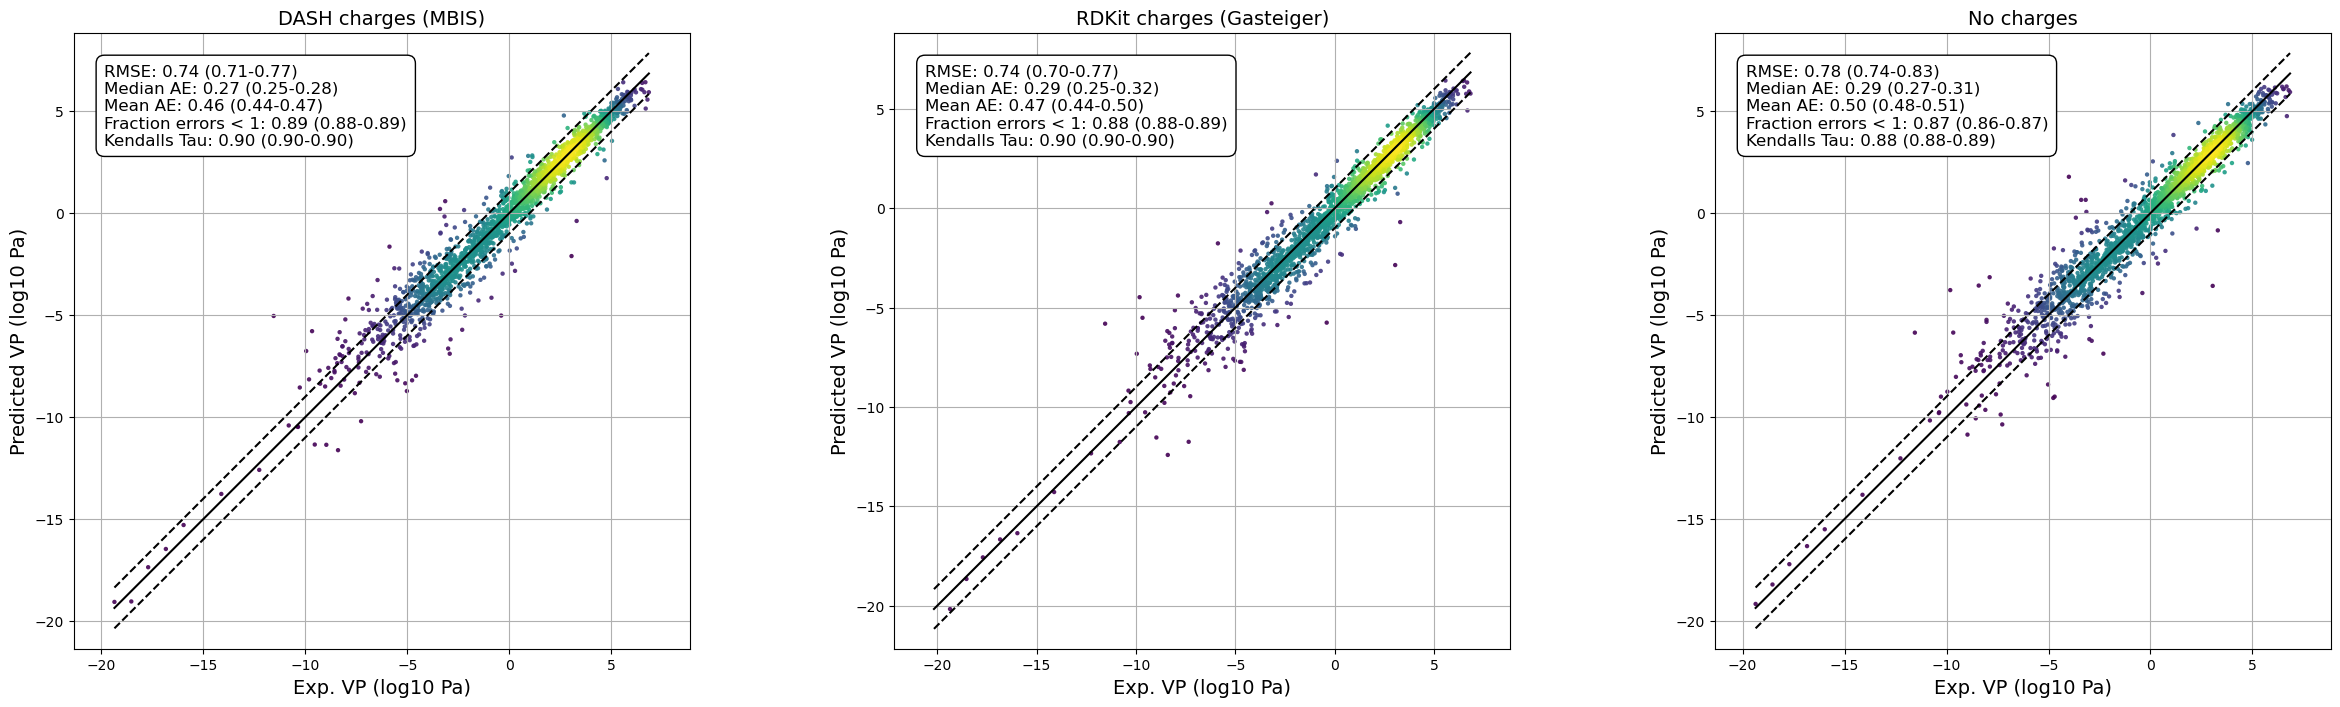

In [38]:
reals_list = [ys_gnn_DASH_charges,ys_gnn_Gasteiger,ys_gnn_no_charge]
predictions_list = [preds_gnn_DASH_charges,preds_gnn_Gasteiger,preds_gnn_no_charge]
molregnos_list = [molregnos_gnn_DASH_charges,molregnos_gnn_Gasteiger,molregnos_gnn_no_charge]
density_plot_multiple_custom_local(reals_list, predictions_list, molregnos_list, title=['DASH charges (MBIS)','RDKit charges (Gasteiger)','No charges'], name='DASH_Gasteiger_no_charge')